# Seleção de Features com Reinforcement Learning

### Contexto

Nas Tasks anteriores foram identificados os dois melhores classificadores para o dataset:

| Modelo | Accuracy | Método de Validação |
|--------|----------|---------------------|
| LDA | 99.93% | Leave-One-Out CV (Task 3) |
| SVM-LINEAR (C=10) | 99.83% | Holdout 80/20 (Task 8) |

Ambos os modelos utilizam todas as 38 features disponíveis. Neste notebook aplicamos **Q-Learning** para identificar subconjuntos reduzidos de features que mantenham boa performance, utilizando validação Holdout 70/30.

### Problema

A seleção de features é um problema combinatório: com 38 features existem $2^{38}$ (~274 mil milhões) subconjuntos possíveis. Métodos exaustivos são computacionalmente impraticáveis, e métodos greedy tradicionais podem ficar presos em ótimos locais.

### Abordagem

O Q-Learning permite explorar o espaço de features de forma inteligente, aprendendo iterativamente quais features contribuem mais para a classificação. O agente:

- **Explora** subconjuntos aleatórios nas fases iniciais
- **Aprende** o valor de cada feature através de recompensas
- **Explota** o conhecimento adquirido para encontrar bons subconjuntos

A função de reward é desenhada para penalizar overfitting, forçando o agente a encontrar subconjuntos que generalizem bem em vez de memorizarem o conjunto de treino.

---
## 1. Configuração

Importação das bibliotecas necessárias para a implementação do Q-Learning. Utilizamos `scikit-learn` para os classificadores (SVM e LDA) e métricas de avaliação, `numpy` para operações matriciais e gestão da Q-table, e `matplotlib`/`seaborn` para visualização dos resultados.

A seed é fixada em 42 para garantir reprodutibilidade dos resultados.

In [1]:
# Imports e Configuração Inicial

# numpy: operações numéricas eficientes (arrays, funções matemáticas, vetorização)
# Utilizado para a Q-table e operações matriciais do Q-Learning
import numpy as np

# pandas: manipulação tabular (DataFrame) para carregar e transformar dados
import pandas as pd

# train_test_split: separa dados em conjuntos de treino e teste (validação hold-out)
from sklearn.model_selection import train_test_split

# StandardScaler: normalização z-score (média=0, desvio=1) para uniformizar escalas das features
from sklearn.preprocessing import StandardScaler

# LabelEncoder: converte classes categóricas (strings) em inteiros (0, 1, 2, ...)
from sklearn.preprocessing import LabelEncoder

# SVC: Support Vector Classifier com kernel linear (um dos dois melhores modelos das Tasks anteriores)
from sklearn.svm import SVC

# LinearDiscriminantAnalysis: classificador LDA (o outro melhor modelo das Tasks anteriores)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Métricas de avaliação:
# - accuracy_score: proporção de predições corretas (acertos / total)
# - classification_report: precision, recall e F1-score por classe
# - confusion_matrix: matriz de confusão (erros por classe)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# matplotlib.pyplot: criação de gráficos básicos (linhas, barras, scatter)
import matplotlib.pyplot as plt

# seaborn: camada de alto nível para visualização estatística (heatmaps, estilos)
import seaborn as sns

# warnings: supressão de avisos irrelevantes para manter output limpo
import warnings

# Suprimir warnings de convergência e deprecação que não afetam resultados
warnings.filterwarnings('ignore')

# Fixar seed para reprodutibilidade dos resultados
# O Q-Learning tem componente estocastica (epsilon-greedy), seed garante mesmos resultados
np.random.seed(42)

# Configuração Visual dos Gráficos
# Estilo de grelha limpa consistente com notebooks anteriores
plt.style.use('seaborn-v0_8-whitegrid')

# Parâmetros globais para uniformizar aparência dos gráficos
plt.rcParams.update({
    'figure.figsize': (12, 5),      # tamanho padrão das figuras
    'figure.dpi': 100,               # resolução para visualização nítida
    'font.size': 10,                 # tamanho base do texto
    'axes.titlesize': 12,            # tamanho dos títulos
    'axes.labelsize': 10,            # tamanho dos rótulos dos eixos
    'axes.titleweight': 'bold',      # títulos em negrito
    'axes.spines.top': False,        # remover linha superior do gráfico
    'axes.spines.right': False,      # remover linha direita do gráfico
    'legend.framealpha': 0.9,        # transparência da caixa de legenda
    'legend.edgecolor': 'none'       # sem contorno na legenda
})

# Paleta de cores personalizada para consistência visual
# Cores distintas para cada modelo e elemento gráfico
COLORS = {
    'svm': '#3498db',      # azul para SVM
    'lda': '#27ae60',      # verde para LDA
    'accent': '#e74c3c',   # vermelho para destaques
    'common': '#9b59b6',   # roxo para features comuns
    'gray': '#bdc3c7',     # cinzento para elementos secundários
    'dark': '#2c3e50'      # azul escuro para texto
}

---
## 2. Dados

Carregamento e pré-processamento do dataset. As transformações aplicadas são idênticas às utilizadas nas Tasks anteriores para garantir comparabilidade:

1. **Correção de `focus_factor`**: conversão de vírgula para ponto decimal
2. **Consolidação de `duration`**: as 5 colunas binárias são combinadas numa única feature ordinal
3. **Remoção de features problemáticas**: `echo_constant` (constante), `is_dance_hit` (derivada), entre outras identificadas na análise exploratória

Após o pré-processamento, dividimos os dados em conjuntos de treino (70%) e validação (30%) com estratificação, e aplicamos standardização (z-score) às features.

In [2]:
# Carregar dataset já preprocessado
# O preprocessing foi centralizado em Data/create_preprocessed_data.py
# Inclui: correção focus_factor, consolidação duration, remoção de features problemáticas
df = pd.read_csv('../Data/group_3_preprocessed.csv')

# Mostrar dimensões finais do dataset
# Esperamos 3000 observações e 39 colunas (38 features + 1 target)
df.shape

(3000, 39)

In [3]:
# Separação de variáveis explicativas (X) e variável alvo (y)
# X: todas as colunas exceto target_class (as 38 features)
# y: coluna target_class que queremos classificar
X = df.drop('target_class', axis=1)
y = df['target_class']

# Converter classes categóricas para inteiros
# LabelEncoder transforma: class_13 para 0, class_74 para 1, class_78 para 2
# Necessário porque sklearn espera valores numéricos
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Guardar nomes das features para uso posterior nos gráficos
# Importante para interpretar quais features são selecionadas pelo Q-Learning
feature_names = list(X.columns)
n_features = len(feature_names)

# Mostrar resumo da estrutura: número de features e classes disponíveis
# le.classes_ contém os nomes originais das classes
print(f"{n_features} features | 3 classes: {', '.join(le.classes_)}")

38 features | 3 classes: class_13, class_74, class_78


In [4]:
# Hold-out (train/validation split):
# - 70% treino (2100 observações): usado para treinar os modelos
# - 30% validação (900 observações): usado para avaliar generalização
# - stratify=y_encoded: mantém proporção das classes em ambos os conjuntos
# - random_state=42: garante reprodutibilidade da divisão
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

# Standardização (z-score normalization):
# Transforma cada feature para ter média=0 e desvio padrão=1
# Importante para SVM (sensível a escalas) e para comparabilidade entre features
scaler = StandardScaler()

# fit_transform no treino: calcula média/desvio e aplica transformação
X_train = scaler.fit_transform(X_train)

# transform no teste: aplica mesma transformação (com parâmetros do treino)
# Nunca fazer fit no teste para evitar data leakage
X_val = scaler.transform(X_val)

# Mostrar tamanho dos conjuntos
print(f"Treino: {X_train.shape[0]} | Validação: {X_val.shape[0]}")

Treino: 2100 | Validação: 900


---
## 3. Função de Reward

A função de reward determina como o agente avalia a qualidade de cada subconjunto de features. O seu desenho é crucial pois define implicitamente o objetivo da aprendizagem.

### Objetivos

1. **Maximizar accuracy de validação** — queremos modelos que generalizem bem
2. **Penalizar overfitting** — evitar subconjuntos que memorizem o treino
3. **Favorecer parsimónia** — preferir subconjuntos mais pequenos

### Implementação

A função implementada avalia cada subconjunto da seguinte forma:

- **Se** accuracy no treino ≥ 99% **ou** gap entre treino e validação ≥ 10%:
  - Retorna reward mínimo (0.05) — penalização por overfitting
- **Caso contrário**:
  - Retorna accuracy de validação menos uma penalização proporcional ao número de features

O threshold de 99% foi escolhido deliberadamente: os modelos baseline atingem ~100% no treino, pelo que forçamos o agente a encontrar subconjuntos que não atinjam perfeição, evitando memorização.

In [5]:
# Função de avaliação para SVM-LINEAR
# Recebe lista de índices de features selecionadas e retorna reward
def evaluate_features_svm(selected_features, penalty=0.05):
    """Avalia subconjunto de features com SVM-LINEAR (C=10)."""
    
    # Caso base: conjunto vazio não tem valor
    if len(selected_features) == 0:
        return 0
    
    # Criar modelo SVM com kernel linear e C=10 (melhor configuração da Task 8)
    model = SVC(kernel='linear', C=10, random_state=42)
    
    # Selecionar apenas as colunas correspondentes às features escolhidas
    # X_train[:, selected_features] usa indexação numpy para extrair colunas
    Xtr, Xva = X_train[:, selected_features], X_val[:, selected_features]
    
    # Treinar modelo e calcular accuracy no treino e validação
    model.fit(Xtr, y_train)
    train_acc = accuracy_score(y_train, model.predict(Xtr))
    test_acc = accuracy_score(y_val, model.predict(Xva))
    
    # Penalização por overfitting:
    # Se accuracy treino >= 99% - modelo está a memorizar
    # Se gap treino-validação >= 10% - modelo não generaliza
    # Nestes casos, retorna reward mínimo (0.05) para desencorajar esta solução
    if train_acc >= 0.99 or (train_acc - test_acc) >= 0.10:
        return penalty
    
    # Reward normal: accuracy de validação menos penalização por número de features
    # Quanto mais features, maior a penalização (incentiva parcimónia)
    return test_acc - 0.01 * len(selected_features) * penalty


# Função de avaliação para LDA
# Estrutura idêntica à do SVM, mas usando classificador LDA
def evaluate_features_lda(selected_features, penalty=0.05):
    """Avalia subconjunto de features com LDA."""
    
    # Caso base: conjunto vazio não tem valor
    if len(selected_features) == 0:
        return 0
    
    # Criar modelo LDA (melhor configuração da Task 3)
    model = LinearDiscriminantAnalysis()
    
    # Selecionar apenas as colunas correspondentes às features escolhidas
    Xtr, Xva = X_train[:, selected_features], X_val[:, selected_features]
    
    # Treinar modelo e calcular accuracy no treino e validação
    model.fit(Xtr, y_train)
    train_acc = accuracy_score(y_train, model.predict(Xtr))
    test_acc = accuracy_score(y_val, model.predict(Xva))
    
    # Penalização por overfitting (mesma lógica do SVM)
    if train_acc >= 0.99 or (train_acc - test_acc) >= 0.10:
        return penalty
    
    # Reward normal: accuracy menos penalização por complexidade
    return test_acc - 0.01 * len(selected_features) * penalty

---
## 4. Algoritmo Q-Learning

O Q-Learning é um algoritmo de Reinforcement Learning model-free que aprende o valor de ações através de tentativa e erro, sem necessitar de um modelo explícito do ambiente.

### Formulação do Problema

| Conceito | Representação |
|----------|---------------|
| **Estado** | Conjunto atual de features selecionadas (vetor binário de 38 posições) |
| **Ação** | Adicionar uma feature ao conjunto (índice 0 a 37) |
| **Reward** | Qualidade do subconjunto avaliada pela função de reward |
| **Q-table** | Vetor com 38 valores — utilidade aprendida de cada feature |

### Processo de Aprendizagem

Em cada episódio, o agente executa os seguintes passos:

1. Inicia com conjunto vazio de features
2. Seleciona feature usando política **epsilon-greedy**: com probabilidade epsilon escolhe aleatoriamente (exploração), caso contrário escolhe a feature com maior Q-value (exploitation)
3. Adiciona a feature ao conjunto e avalia com o classificador
4. Calcula o reward incremental e atualiza o Q-value usando: `Q[a] = Q[a] + alpha*(r + gamma*max(Q) - Q[a])`
5. Repete até percorrer todas as features

### Parâmetros

| Parâmetro | Valor | Descrição |
|-----------|-------|-----------|
| Episódios | 15 | Iterações completas de aprendizagem |
| epsilon | 0.5 (inicial) | Taxa de exploração, decai 3% por episódio (minimo 0.01) |
| alpha | 0.1 | Taxa de aprendizagem |
| gamma | 0.9 | Fator de desconto para recompensas futuras |

In [6]:
# Implementação do algoritmo Q-Learning para seleção de features
# Parâmetros:
# - evaluate_fn: função de avaliação (SVM ou LDA)
# - n_features: número total de features disponíveis
# - model_name: nome do modelo para output
# - episodes: número de iterações completas de aprendizagem
# - epsilon: taxa inicial de exploração (probabilidade de escolha aleatória)
# - alpha: taxa de aprendizagem (peso das novas observações)
# - gamma: fator de desconto (importância de recompensas futuras)
# - penalty: valor de penalização para overfitting

def q_learning_feature_selection(evaluate_fn, n_features, model_name,
                                  episodes=15, epsilon=0.5, alpha=0.1, 
                                  gamma=0.9, penalty=0.05, verbose=True):
    """Q-Learning para seleção de features."""
    
    # Inicializar Q-table como vetor de zeros
    # Cada posição representa o valor aprendido (utilidade) de cada feature
    Q = np.zeros(n_features)
    
    # Listas para guardar histórico de aprendizagem (para gráficos)
    rewards_history = []      # reward total por episódio
    best_acc_history = []     # melhor accuracy acumulada
    epsilon_history = [epsilon]  # evolução do epsilon
    tested_subsets = []       # todos os subconjuntos testados
    episode_details = []      # detalhes de cada episódio
    current_best = 0          # melhor resultado global
    
    # Mostrar configuração inicial
    print(f"Q-Learning: {model_name}")
    print(f"Parametros: episodes={episodes}, epsilon={epsilon}, alpha={alpha}, gamma={gamma}\n")
    
    # Loop principal: executar múltiplos episódios de aprendizagem
    for ep in range(episodes):
        # Estado inicial: nenhuma feature selecionada (vetor binário de zeros)
        state = np.zeros(n_features, dtype=int)
        
        # Variáveis do episódio
        selected = []           # lista de features selecionadas
        episode_reward = 0      # reward acumulado no episódio
        prev_acc = 0            # accuracy anterior (para calcular reward incremental)
        ep_best = 0             # melhor resultado do episódio
        
        # Loop interno: tentar selecionar features uma a uma
        for step in range(n_features):
            # Política epsilon-greedy:
            # Com probabilidade epsilon: exploração (escolha aleatória)
            # Com probabilidade 1-epsilon: exploitation (escolha com maior Q-value)
            if np.random.rand() < epsilon:
                action = np.random.randint(0, n_features)  # exploração
            else:
                action = np.argmax(Q)  # exploitation
            
            # Verificar se a feature já foi selecionada
            # Se sim, ignorar esta ação (não podemos selecionar duas vezes)
            if state[action] == 1:
                continue
            
            # Adicionar feature ao estado e à lista de selecionadas
            state[action] = 1
            selected.append(action)
            
            # Avaliar o subconjunto atual com o classificador
            acc = evaluate_fn(selected, penalty)
            
            # Calcular reward incremental (melhoria face ao passo anterior)
            # Reward positivo se a nova feature melhorou o resultado
            reward = acc - prev_acc
            prev_acc = acc
            
            # Atualização Q-Learning:
            # Q[a] = Q[a] + alpha * (r + gamma * max(Q) - Q[a])
            # Esta fórmula ajusta o Q-value com base na recompensa obtida
            # e no valor esperado das melhores ações futuras
            Q[action] = Q[action] + alpha * (reward + gamma * np.max(Q) - Q[action])
            
            # Acumular reward do episódio
            episode_reward += reward
            
            # Guardar subconjunto testado para análise posterior
            tested_subsets.append((state.copy(), acc))
            
            # Atualizar melhor resultado do episódio
            ep_best = max(ep_best, acc)
        
        # Guardar resultados do episódio
        rewards_history.append(episode_reward)
        current_best = max(current_best, ep_best)
        best_acc_history.append(current_best)
        episode_details.append({'episode': ep+1, 'reward': episode_reward, 'best_acc': ep_best})
        
        # Mostrar progresso
        if verbose:
            print(f"Episodio {ep+1:2d}: reward = {episode_reward:.4f}, best = {ep_best:.4f}")
        
        # Decaimento do epsilon (3% por episódio)
        # Começa com mais exploração e gradualmente passa a exploitation
        epsilon = max(0.01, epsilon * 0.97)
        epsilon_history.append(epsilon)
    
    # Encontrar o melhor subconjunto entre todos os testados
    # Critério: maior reward (accuracy ajustada pela penalização)
    best_state, best_reward = max(tested_subsets, key=lambda x: x[1])
    
    # Extrair índices das features selecionadas no melhor subconjunto
    best_features = np.where(best_state == 1)[0]
    
    # Mostrar resultado final
    print(f"\nMelhor subconjunto encontrado:")
    print(f"  Vetor binario: {best_state}")
    print(f"  Indices: {list(best_features)}")
    print(f"  Reward: {best_reward:.4f}")
    
    # Retornar dicionário com todos os resultados para análise posterior
    return {
        'Q': Q,                          # Q-table final
        'rewards': rewards_history,       # histórico de rewards
        'best_acc_history': best_acc_history,  # convergência
        'epsilon_history': epsilon_history,    # decaimento de epsilon
        'best_features': best_features,   # índices das melhores features
        'best_acc': best_reward,          # melhor reward obtido
        'best_state': best_state,         # vetor binário do melhor estado
        'model_name': model_name,         # nome do modelo
        'episode_details': episode_details,    # detalhes por episódio
        'tested_subsets': tested_subsets  # todos os subconjuntos testados
    }

---
## 5. Resultados: SVM-LINEAR

Execução do Q-Learning utilizando o classificador SVM com kernel linear e C=10.

Este modelo obteve 99.83% de accuracy na Task 8 utilizando todas as 38 features. O objetivo é encontrar um subconjunto reduzido que mantenha boa capacidade discriminativa sem overfitting.

A saída mostra a evolução do reward ao longo dos 15 episódios e o melhor subconjunto encontrado (representado como vetor binário e lista de índices).

In [7]:
# Executar Q-Learning com o classificador SVM-LINEAR
# Parâmetros escolhidos:
# - episodes=15: número de iterações (equilíbrio entre exploração e tempo)
# - epsilon=0.5: começa com 50% exploração (escolhas aleatórias)
# - alpha=0.1: taxa de aprendizagem moderada (atualiza Q-values gradualmente)
# - gamma=0.9: valoriza recompensas futuras (90% do valor máximo futuro)
# - penalty=0.05: penalização por número de features e overfitting

results_svm = q_learning_feature_selection(
    evaluate_fn=evaluate_features_svm,
    n_features=n_features,
    model_name="SVM-LINEAR (C=10)",
    episodes=15, epsilon=0.5, alpha=0.1, gamma=0.9, penalty=0.05
)

Q-Learning: SVM-LINEAR (C=10)
Parametros: episodes=15, epsilon=0.5, alpha=0.1, gamma=0.9

Episodio  1: reward = 0.8930, best = 0.8930
Episodio  2: reward = 0.8118, best = 0.8118
Episodio  3: reward = 0.8847, best = 0.8847
Episodio  4: reward = 0.8369, best = 0.8369
Episodio  5: reward = 0.8619, best = 0.8619
Episodio  6: reward = 0.5350, best = 0.5350
Episodio  7: reward = 0.8619, best = 0.8619
Episodio  8: reward = 0.8089, best = 0.8089
Episodio  9: reward = 0.8581, best = 0.8581
Episodio 10: reward = 0.8235, best = 0.8317
Episodio 11: reward = 0.8217, best = 0.8217
Episodio 12: reward = 0.8296, best = 0.8306
Episodio 13: reward = 0.0500, best = 0.8898
Episodio 14: reward = 0.7602, best = 0.7602
Episodio 15: reward = 0.8250, best = 0.8250

Melhor subconjunto encontrado:
  Vetor binario: [0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0]
  Indices: [1, 2, 3, 5, 6, 7, 10, 16, 17, 18, 20, 24, 27, 28]
  Reward: 0.8930


In [8]:
# Calcular accuracy real do modelo SVM com as features selecionadas
# O reward inclui penalizações, por isso recalculamos a accuracy pura

# Criar e treinar modelo SVM apenas com as features selecionadas pelo Q-Learning
svm_model = SVC(kernel='linear', C=10, random_state=42)
svm_model.fit(X_train[:, results_svm['best_features']], y_train)

# Calcular accuracy no conjunto de validação
svm_acc = accuracy_score(y_val, svm_model.predict(X_val[:, results_svm['best_features']]))

# Mostrar resultados formatados
print(f"SVM-LINEAR - Features Selecionadas")
print(f"Accuracy: {svm_acc:.2%} ({len(results_svm['best_features'])}/{n_features} features)\n")

# Listar cada feature selecionada com o seu Q-value aprendido
# Q-value indica a utilidade média da feature durante a aprendizagem
for i, idx in enumerate(results_svm['best_features']):
    print(f"  {i+1:2d}. {feature_names[idx]:<28} Q={results_svm['Q'][idx]:.3f}")

SVM-LINEAR - Features Selecionadas
Accuracy: 90.00% (14/38 features)

   1. popularity_level             Q=0.078
   2. tempo_class                  Q=0.112
   3. time_signature               Q=0.072
   4. artist_song_count            Q=0.186
   5. album_freq                   Q=0.077
   6. movement_index               Q=0.095
   7. purity_score                 Q=0.131
   8. artists_avg_popularity       Q=0.145
   9. tempo_vs_genre               Q=0.065
  10. energy_rank_pct              Q=0.110
  11. mood_pca                     Q=0.150
  12. signal_strength              Q=0.162
  13. ambient_level                Q=0.093
  14. key_sin                      Q=0.353


### Análise dos Resultados - SVM

O algoritmo selecionou **14 das 38 features** (37%), alcançando **90% de accuracy** no conjunto de validação. Este resultado representa uma redução de quase 10 pontos percentuais face ao baseline de 99.78%, mas com menos de metade das features originais.

**Comportamento da aprendizagem:** A maioria dos episódios obteve rewards entre 0.80 e 0.89, o que indica subconjuntos com boa capacidade de generalização. Destacam-se dois episódios problemáticos: o episódio 6 (reward 0.535) e o episódio 13 (reward 0.05). Neste último, a penalização de overfitting foi ativada, significando que o subconjunto testado atingiu accuracy de treino superior a 99%.

**Q-values aprendidos:** A feature `key_sin` destaca-se com o Q-value mais elevado (0.353), mais do dobro da segunda classificada (`artist_song_count` com 0.186). Isto sugere que a codificação sinusoidal da tonalidade é particularmente útil para o SVM distinguir entre as três classes. Outras features relevantes incluem `signal_strength` (0.162), `mood_pca` (0.150) e `artists_avg_popularity` (0.145).

**Natureza das features selecionadas:** O subconjunto inclui uma mistura interessante de características: métricas de popularidade (`popularity_level`, `artists_avg_popularity`), propriedades musicais básicas (`tempo_class`, `time_signature`, `key_sin`) e features derivadas que capturam relações entre atributos (`tempo_vs_genre`, `mood_pca`, `energy_rank_pct`).

---
## 6. Resultados: LDA

Execução do Q-Learning utilizando o classificador LDA (Linear Discriminant Analysis).

Este modelo obteve 99.93% de accuracy na Task 3 utilizando todas as 38 features. Sendo um modelo linear baseado em projeções, o LDA pode beneficiar particularmente da remoção de features ruidosas ou redundantes.

A comparação com o SVM permite avaliar se as features importantes são consistentes entre classificadores com estratégias distintas.

In [9]:
# Executar Q-Learning com o classificador LDA
# Usa os mesmos parâmetros do SVM para comparação justa
# A diferença está apenas na função de avaliação (evaluate_features_lda)

results_lda = q_learning_feature_selection(
    evaluate_fn=evaluate_features_lda,
    n_features=n_features,
    model_name="LDA",
    episodes=15, epsilon=0.5, alpha=0.1, gamma=0.9, penalty=0.05
)

Q-Learning: LDA
Parametros: episodes=15, epsilon=0.5, alpha=0.1, gamma=0.9

Episodio  1: reward = 0.0500, best = 0.7906
Episodio  2: reward = 0.8253, best = 0.8292
Episodio  3: reward = 0.8545, best = 0.8545
Episodio  4: reward = 0.7807, best = 0.7894
Episodio  5: reward = 0.8397, best = 0.8397
Episodio  6: reward = 0.8161, best = 0.8161
Episodio  7: reward = 0.8023, best = 0.8066
Episodio  8: reward = 0.0500, best = 0.6998
Episodio  9: reward = 0.8430, best = 0.8430
Episodio 10: reward = 0.8584, best = 0.8584
Episodio 11: reward = 0.8362, best = 0.8378
Episodio 12: reward = 0.0500, best = 0.7113
Episodio 13: reward = 0.7935, best = 0.7989
Episodio 14: reward = 0.8628, best = 0.8628
Episodio 15: reward = 0.7992, best = 0.8058

Melhor subconjunto encontrado:
  Vetor binario: [0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 1]
  Indices: [5, 7, 8, 15, 17, 20, 24, 32, 33, 37]
  Reward: 0.8628


In [10]:
# Calcular accuracy real do modelo LDA com as features selecionadas

# Criar e treinar modelo LDA apenas com as features selecionadas pelo Q-Learning
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train[:, results_lda['best_features']], y_train)

# Calcular accuracy no conjunto de validação
lda_acc = accuracy_score(y_val, lda_model.predict(X_val[:, results_lda['best_features']]))

# Mostrar resultados formatados
print(f"LDA - Features Selecionadas")
print(f"Accuracy: {lda_acc:.2%} ({len(results_lda['best_features'])}/{n_features} features)\n")

# Listar cada feature selecionada com o seu Q-value aprendido
for i, idx in enumerate(results_lda['best_features']):
    print(f"  {i+1:2d}. {feature_names[idx]:<28} Q={results_lda['Q'][idx]:.3f}")

LDA - Features Selecionadas
Accuracy: 86.78% (10/38 features)

   1. artist_song_count            Q=0.118
   2. movement_index               Q=0.116
   3. intensity_level              Q=0.655
   4. acoustics_instrumental       Q=0.125
   5. tempo_vs_genre               Q=0.078
   6. mood_pca                     Q=0.143
   7. signal_strength              Q=0.190
   8. loudness_yeo                 Q=0.120
   9. is_instrumental              Q=0.128
  10. duration                     Q=0.142


### Análise dos Resultados - LDA

O algoritmo selecionou **10 das 38 features** (26%), alcançando **86.78% de accuracy**. Comparado com o baseline de 100%, a redução é de cerca de 13 pontos percentuais, mas o modelo opera agora com apenas um quarto das features originais.

**Comportamento da aprendizagem:** A aprendizagem foi menos estável que no SVM. Três episódios (1, 8 e 12) obtiveram o reward mínimo de 0.05, indicando que o LDA é mais propenso a atingir overfitting com determinadas combinações de features. Isto faz sentido: o LDA assume distribuições gaussianas e procura projeções lineares ótimas, sendo mais sensível à presença de features ruidosas ou correlacionadas.

**Q-values aprendidos:** O resultado mais marcante é o Q-value de `intensity_level` (0.655), que é cerca de 5 vezes superior ao das outras features. Este valor excecionalmente alto indica que esta feature é crítica para a separação linear das classes no LDA. As restantes features têm Q-values relativamente uniformes entre 0.078 e 0.190, sugerindo contribuições mais equilibradas.

**Natureza das features selecionadas:** O LDA privilegiou características de áudio e produção: `intensity_level`, `loudness_yeo`, `acoustics_instrumental` e `is_instrumental` são todas relacionadas com propriedades sonoras. A inclusão de `duration` é interessante — a duração das músicas pode correlacionar-se com géneros ou estilos específicos de cada classe.

**Comparação com SVM:** O fato de o LDA ter selecionado menos features (10 vs 14) mas obtido accuracy inferior (86.78% vs 90%) sugere que este classificador é mais exigente na qualidade das features, não conseguindo compensar a informação perdida tão eficazmente quanto o SVM.

---
## 7. Análise da Aprendizagem

Visualização do comportamento do Q-Learning ao longo dos episódios através de três perspetivas:

1. **Evolução do Reward**: reward total obtido em cada episódio — valores baixos indicam que a penalização de overfitting foi ativada
2. **Convergência**: melhor reward acumulado ao longo do tempo — mostra quão rapidamente o algoritmo encontra boas soluções
3. **Epsilon Decay**: transição gradual de exploração (escolhas aleatórias) para exploitation (escolhas guiadas pelos Q-values)

Os gráficos de Q-values mostram as 12 features com maior valor aprendido para cada modelo, destacando quais foram efetivamente incluídas no melhor subconjunto.

O mapa de seleção apresenta uma visão matricial de quais features foram selecionadas por cada modelo, evidenciando as features comuns.

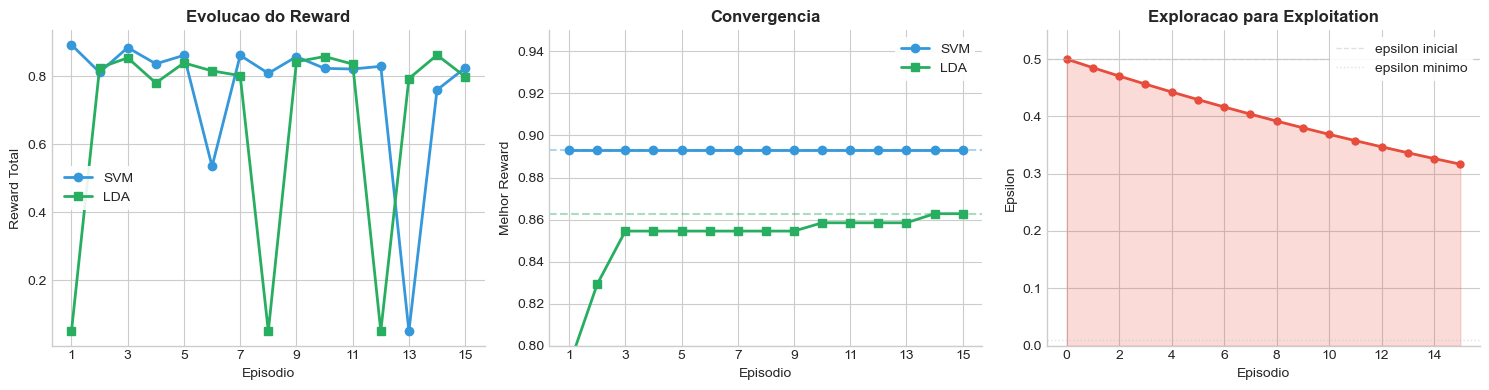

In [11]:
# Visualização da convergência do Q-Learning
# Três gráficos lado a lado para analisar o comportamento da aprendizagem

# Criar figura com 3 subplots horizontais (1 linha, 3 colunas)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Gráfico 1: Evolução do Reward por Episódio
# Mostra o reward total obtido em cada episódio de aprendizagem
# Rewards baixos indicam episódios onde a penalização de overfitting foi ativada
ax = axes[0]
ax.plot(range(1, 16), results_svm['rewards'], 'o-', color=COLORS['svm'], lw=2, ms=6, label='SVM')
ax.plot(range(1, 16), results_lda['rewards'], 's-', color=COLORS['lda'], lw=2, ms=6, label='LDA')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward Total')
ax.set_title('Evolucao do Reward')
ax.legend(frameon=True)
ax.set_xticks(range(1, 16, 2))

# Gráfico 2: Convergência (Melhor Reward Acumulado)
# Mostra quão rapidamente o algoritmo encontra boas soluções
# Linhas horizontais tracejadas indicam o melhor resultado final de cada modelo
ax = axes[1]
ax.plot(range(1, 16), results_svm['best_acc_history'], 'o-', color=COLORS['svm'], lw=2, ms=6, label='SVM')
ax.plot(range(1, 16), results_lda['best_acc_history'], 's-', color=COLORS['lda'], lw=2, ms=6, label='LDA')
ax.axhline(results_svm['best_acc'], color=COLORS['svm'], ls='--', alpha=0.4, lw=1.5)
ax.axhline(results_lda['best_acc'], color=COLORS['lda'], ls='--', alpha=0.4, lw=1.5)
ax.set_xlabel('Episodio')
ax.set_ylabel('Melhor Reward')
ax.set_title('Convergencia')
ax.legend(frameon=True)
ax.set_xticks(range(1, 16, 2))
ax.set_ylim(0.80, 0.95)

# Gráfico 3: Epsilon Decay (Exploracao para Exploitation)
# Mostra a transição gradual de exploração (escolhas aleatórias) para exploitation
# Área preenchida visualiza a diminuição da taxa de exploração ao longo dos episódios
ax = axes[2]
ax.fill_between(range(16), results_svm['epsilon_history'], alpha=0.2, color=COLORS['accent'])
ax.plot(range(16), results_svm['epsilon_history'], 'o-', color=COLORS['accent'], lw=2, ms=5)
ax.axhline(0.5, color=COLORS['gray'], ls='--', alpha=0.5, lw=1, label='epsilon inicial')
ax.axhline(0.01, color=COLORS['gray'], ls=':', alpha=0.5, lw=1, label='epsilon minimo')
ax.set_xlabel('Episodio')
ax.set_ylabel('Epsilon')
ax.set_title('Exploracao para Exploitation')
ax.legend(frameon=True, loc='upper right')
ax.set_ylim(0, 0.55)

# Ajustar layout para evitar sobreposição de elementos
plt.tight_layout()
plt.show()

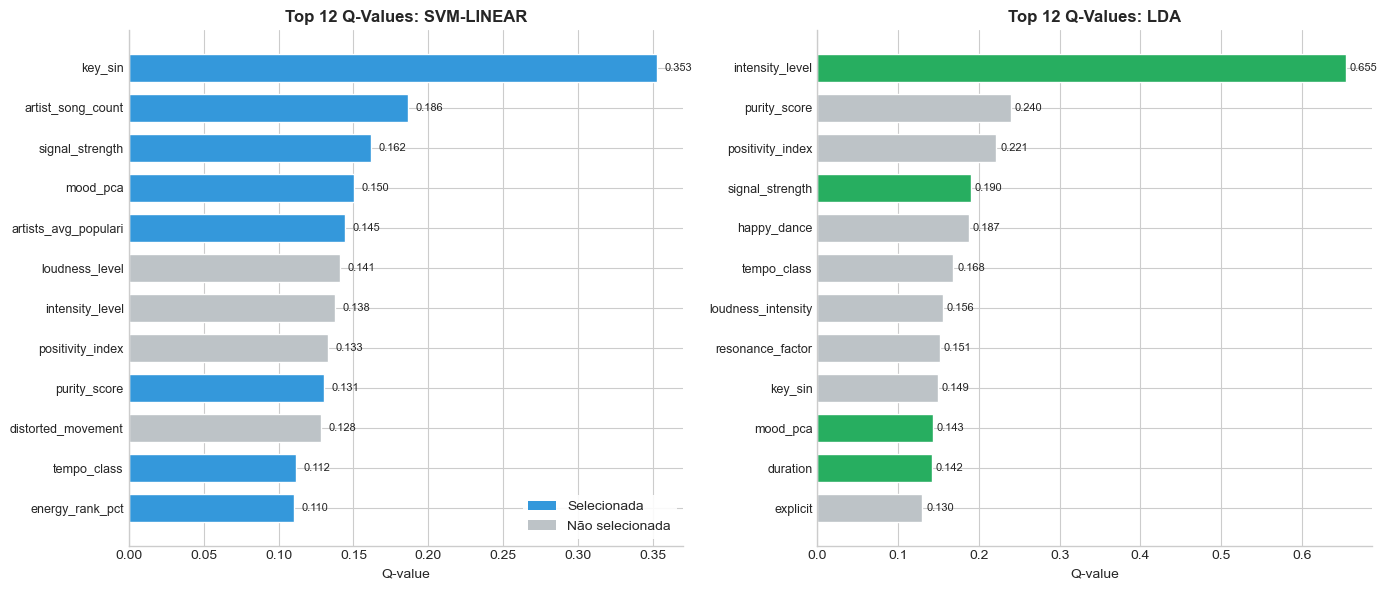

In [12]:
# Visualização dos Q-values aprendidos para cada modelo
# Barras horizontais mostram as 12 features com maior Q-value
# Cor indica se a feature foi incluída no melhor subconjunto (colorida) ou não (cinzenta)

# Criar figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loop para criar gráfico para cada modelo (SVM e LDA)
for ax, results, color, title in [(axes[0], results_svm, COLORS['svm'], 'SVM-LINEAR'),
                                   (axes[1], results_lda, COLORS['lda'], 'LDA')]:
    # Extrair Q-values e ordenar por valor decrescente
    Q = results['Q']
    top_idx = np.argsort(Q)[::-1][:12]  # índices das 12 maiores
    
    # Obter nomes das features (truncados a 20 caracteres para caber)
    top_names = [feature_names[i][:20] for i in top_idx]
    top_values = Q[top_idx]
    
    # Definir cor de cada barra:
    # - Cor do modelo se a feature está no melhor subconjunto
    # - Cinzento se não foi selecionada
    bar_colors = [color if i in results['best_features'] else COLORS['gray'] for i in top_idx]
    
    # Desenhar barras horizontais
    bars = ax.barh(range(len(top_names)), top_values, color=bar_colors, edgecolor='white', height=0.7)
    
    # Configurar eixo Y com nomes das features
    ax.set_yticks(range(len(top_names)))
    ax.set_yticklabels(top_names, fontsize=9)
    ax.invert_yaxis()  # maior Q-value no topo
    
    # Labels e título
    ax.set_xlabel('Q-value')
    ax.set_title(f'Top 12 Q-Values: {title}')
    
    # Adicionar valor numérico ao lado de cada barra
    for bar, val in zip(bars, top_values):
        ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=8)

# Adicionar legenda explicativa
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLORS['svm'], label='Selecionada'),
                   Patch(facecolor=COLORS['gray'], label='Não selecionada')]
axes[0].legend(handles=legend_elements, loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

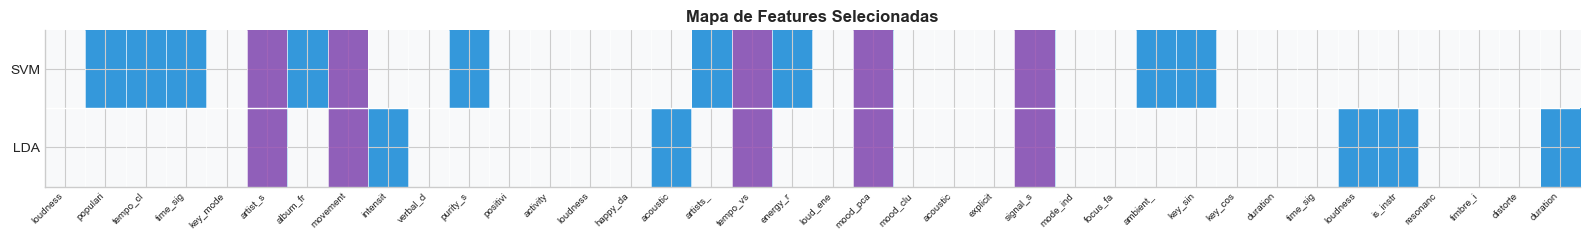

In [13]:
# Mapa de seleção de features
# Visualização matricial mostrando quais features foram selecionadas por cada modelo
# Features comuns aparecem destacadas em roxo

# Criar figura com dimensões adequadas para 38 features
fig, ax = plt.subplots(figsize=(16, 2.5))

# Construir matriz de seleção (2 linhas x 38 colunas)
# Linha 0: SVM, Linha 1: LDA
# Valor 1 indica feature selecionada, 0 indica não selecionada
selection = np.zeros((2, n_features))
selection[0, results_svm['best_features']] = 1
selection[1, results_lda['best_features']] = 1

# Criar colormap personalizado: branco para não selecionada, azul para selecionada
cmap = plt.cm.colors.ListedColormap(['#f8f9fa', COLORS['svm']])
im = ax.imshow(selection, aspect='auto', cmap=cmap, vmin=0, vmax=1)

# Identificar e destacar features comuns a ambos os modelos
# Interseção dos conjuntos de features selecionadas
common = set(results_svm['best_features']) & set(results_lda['best_features'])

# Desenhar retângulos roxos sobre as features comuns
for i in common:
    ax.add_patch(plt.Rectangle((i-0.5, -0.5), 1, 2, fill=True, facecolor=COLORS['common'], alpha=0.9))

# Configurar eixos
ax.set_yticks([0, 1])
ax.set_yticklabels(['SVM', 'LDA'], fontsize=10)
ax.set_xticks(range(n_features))
# Truncar nomes das features a 8 caracteres para caber
ax.set_xticklabels([f[:8] for f in feature_names], rotation=45, ha='right', fontsize=7)
ax.set_title('Mapa de Features Selecionadas', fontsize=12, fontweight='bold')

# Adicionar linhas de grelha para separar células
for i in range(n_features + 1):
    ax.axvline(i - 0.5, color='white', linewidth=0.5)
ax.axhline(0.5, color='white', linewidth=1)

plt.tight_layout()
plt.show()

### Observações sobre a Aprendizagem

**Gráfico de Evolução do Reward:** A linha do SVM mantém-se geralmente acima da do LDA, indicando que o SVM encontra subconjuntos com melhor generalização de forma mais consistente. Os pontos muito baixos (próximos de 0.05) correspondem a episódios onde a penalização de overfitting foi ativada. Note-se que o LDA tem mais destes pontos (3 episódios) que o SVM (1 episódio).

**Gráfico de Convergência:** O melhor resultado para o SVM (0.893) foi encontrado logo no primeiro episódio e não foi superado nos restantes 14 episódios. Isto pode parecer surpreendente, mas ilustra a natureza estocástica do Q-Learning: nem sempre a exploração tardia melhora os resultados iniciais. Para o LDA, o melhor resultado (0.863) surgiu apenas no episódio 14, demonstrando que a exploração continuada trouxe benefícios.

**Gráfico de Epsilon Decay:** O epsilon começa em 0.5 (50% exploração) e decai para aproximadamente 0.32 no final dos 15 episódios. Este decay relativamente lento significa que o agente mantém uma componente exploratória significativa ao longo de toda a aprendizagem, evitando convergência prematura para soluções subótimas.

**Gráficos de Q-Values:** A distribuição dos Q-values revela estratégias diferentes. O SVM tem valores mais distribuídos (máximo 0.353, várias features entre 0.07-0.18), enquanto o LDA concentra quase todo o valor numa única feature (`intensity_level` com 0.655). Algumas features com Q-values elevados não aparecem no melhor subconjunto (barras cinzentas) — isto acontece porque o Q-value representa a utilidade média da feature, não a sua presença no melhor subconjunto específico encontrado.

**Mapa de Seleção:** As 5 features comuns (roxo) representam apenas 13% do total de features, mas a sua seleção por ambos os modelos é um forte indicador de relevância. Curiosamente, estas features comuns não incluem as que têm os Q-values mais altos individualmente (`key_sin` para SVM, `intensity_level` para LDA), sugerindo que features "universalmente úteis" podem não ser as mesmas que features "excepcionalmente úteis para um modelo específico".

---
## 8. Avaliação dos Modelos

Avaliação comparativa entre os modelos baseline (38 features) e os modelos com features selecionadas pelo Q-Learning.

Para cada configuração calculamos:
- **Accuracy de treino e validação**: permite detetar overfitting
- **Confusion matrix**: visualização dos erros por classe
- **Classification report**: precision, recall e F1-score por classe

Esta avaliação permite quantificar o trade-off entre redução de dimensionalidade e perda de accuracy.

In [14]:
# Avaliação final dos modelos com features selecionadas
# Compara performance entre baseline (38 features) e Q-Learning (features selecionadas)

def evaluate_model(model, features):
    """Treina e avalia um modelo com um subconjunto de features."""
    # Selecionar apenas as colunas correspondentes às features
    Xtr, Xva = X_train[:, features], X_val[:, features]
    
    # Treinar modelo
    model.fit(Xtr, y_train)
    
    # Gerar predições no conjunto de validação
    y_pred = model.predict(Xva)
    
    # Retornar métricas e predições
    return {
        'train_acc': accuracy_score(y_train, model.predict(Xtr)),  # accuracy treino
        'val_acc': accuracy_score(y_val, y_pred),                   # accuracy validação
        'cm': confusion_matrix(y_val, y_pred),                      # matriz de confusão
        'y_pred': y_pred                                            # predições (para classification report)
    }

# Avaliar modelos com features selecionadas pelo Q-Learning
eval_svm = evaluate_model(SVC(kernel='linear', C=10, random_state=42), results_svm['best_features'])
eval_lda = evaluate_model(LinearDiscriminantAnalysis(), results_lda['best_features'])

# Calcular baselines (modelos com todas as 38 features)
# Estes valores servem de referência para quantificar o impacto da seleção de features
baseline_svm = SVC(kernel='linear', C=10, random_state=42).fit(X_train, y_train).score(X_val, y_val)
baseline_lda = LinearDiscriminantAnalysis().fit(X_train, y_train).score(X_val, y_val)

In [15]:
# Tabela comparativa: Baseline vs Q-Learning
# Mostra a diferença de performance entre usar todas as features e usar apenas as selecionadas

print("Comparacao Baseline vs Q-Learning:\n")

# Cabeçalho da tabela
print(f"{'Modelo':<12} {'Baseline':>10} {'Q-Learning':>12} {'Diferenca':>10} {'Features':>10}")
print("-" * 58)

# Linha SVM: accuracy baseline, accuracy Q-Learning, diferença percentual, número de features
print(f"{'SVM-LINEAR':<12} {baseline_svm:>10.2%} {eval_svm['val_acc']:>12.2%} {(eval_svm['val_acc']-baseline_svm)*100:>+9.1f}% {len(results_svm['best_features']):>4}/{n_features}")

# Linha LDA: mesma estrutura
print(f"{'LDA':<12} {baseline_lda:>10.2%} {eval_lda['val_acc']:>12.2%} {(eval_lda['val_acc']-baseline_lda)*100:>+9.1f}% {len(results_lda['best_features']):>4}/{n_features}")

# Mostrar redução de dimensionalidade
# Indica quantas features foram removidas e a percentagem de redução
print(f"\nReducao de dimensionalidade:")
print(f"  SVM: {n_features - len(results_svm['best_features'])} features removidas ({(1-len(results_svm['best_features'])/n_features)*100:.0f}%)")
print(f"  LDA: {n_features - len(results_lda['best_features'])} features removidas ({(1-len(results_lda['best_features'])/n_features)*100:.0f}%)")

Comparacao Baseline vs Q-Learning:

Modelo         Baseline   Q-Learning  Diferenca   Features
----------------------------------------------------------
SVM-LINEAR       99.78%       90.00%      -9.8%   14/38
LDA             100.00%       86.78%     -13.2%   10/38

Reducao de dimensionalidade:
  SVM: 24 features removidas (63%)
  LDA: 28 features removidas (74%)


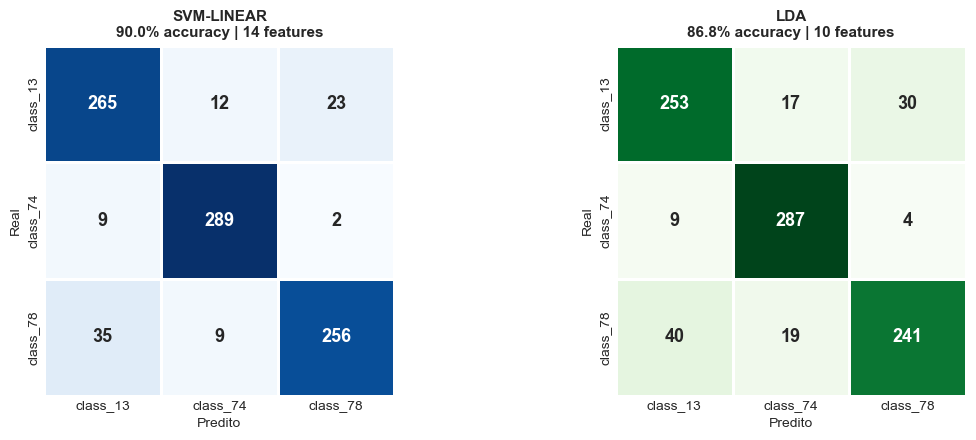

In [16]:
# Matrizes de confusão para ambos os modelos
# Visualização dos erros de classificação por classe

# Criar figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Loop para criar heatmap para cada modelo
for ax, eval_data, n_feat, title, cmap, color in [
    (axes[0], eval_svm, len(results_svm['best_features']), 'SVM-LINEAR', 'Blues', COLORS['svm']),
    (axes[1], eval_lda, len(results_lda['best_features']), 'LDA', 'Greens', COLORS['lda'])
]:
    # Extrair matriz de confusão
    cm = eval_data['cm']
    
    # Criar heatmap com seaborn
    # annot=True: mostrar valores dentro das células
    # fmt='d': formato inteiro (sem casas decimais)
    # xticklabels/yticklabels: usar nomes originais das classes
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={'size': 13, 'weight': 'bold'}, 
                cbar=False, linewidths=2, linecolor='white', square=True)
    
    # Labels dos eixos
    ax.set_xlabel('Predito', fontsize=10)
    ax.set_ylabel('Real', fontsize=10)
    
    # Título com accuracy e número de features
    ax.set_title(f'{title}\n{eval_data["val_acc"]:.1%} accuracy | {n_feat} features', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Classification reports detalhados
# Mostra precision, recall e F1-score por classe para cada modelo
# Permite identificar quais classes são mais difíceis de classificar

# Classification report para SVM
# target_names: usar nomes originais das classes (class_13, class_74, class_78)
print("SVM-LINEAR Classification Report:\n")
print(classification_report(y_val, eval_svm['y_pred'], target_names=le.classes_))

# Classification report para LDA
print("\nLDA Classification Report:\n")
print(classification_report(y_val, eval_lda['y_pred'], target_names=le.classes_))

SVM-LINEAR Classification Report:

              precision    recall  f1-score   support

    class_13       0.86      0.88      0.87       300
    class_74       0.93      0.96      0.95       300
    class_78       0.91      0.85      0.88       300

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900


LDA Classification Report:

              precision    recall  f1-score   support

    class_13       0.84      0.84      0.84       300
    class_74       0.89      0.96      0.92       300
    class_78       0.88      0.80      0.84       300

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



### Análise Comparativa

**Tabela de resultados:** O SVM com Q-Learning atinge 90% accuracy com 14 features, enquanto o LDA fica em 86.78% com 10 features. Em ambos os casos, os modelos baseline (com 38 features) aproximam-se de 100%, pelo que a redução de accuracy é substancial. No entanto, esta era a intenção do desenho da função de reward — evitar subconjuntos que produzam overfitting.

**Confusion matrices:** Ambos os modelos classificam bem a **class_74**, com apenas 12-14 erros em 300 exemplos. A **class_78** é a mais problemática: o SVM erra 44 exemplos e o LDA erra 60. A maioria destes erros são confusões com class_13 (26 no SVM, 45 no LDA), sugerindo que estas duas classes têm maior sobreposição no espaço de features reduzido.

**Classification reports — SVM:**
- A **class_74** tem o melhor desempenho (precision 93%, recall 96%, F1 95%)
- A **class_13** e **class_78** têm F1-scores semelhantes (~87-88%), mas com padrões diferentes: class_13 tem melhor recall (88% vs 85%) enquanto class_78 tem melhor precision (91% vs 86%)
- O macro average de 90% indica performance equilibrada entre classes

**Classification reports — LDA:**
- Novamente, **class_74** lidera com F1 de 92%
- **class_13** e **class_78** têm F1 idênticos (84%), mas class_78 sofre de baixo recall (80%)
- O padrão de erros é consistente com o SVM: class_78 é sistematicamente confundida com class_13

**Interpretação:** A dificuldade com class_78 pode indicar que esta classe depende de features que foram eliminadas durante a seleção, ou que as suas características se sobrepõem naturalmente com class_13. O fato de ambos os modelos partilharem esta fraqueza sugere que é uma propriedade do espaço de features reduzido, não do classificador em si.

---
## 9. Discussão

Análise aprofundada dos resultados, focando em três aspetos:

1. **Comparação quantitativa**: gráficos de barras que comparam accuracy, recall e precision entre baseline e Q-Learning para ambos os modelos
2. **Redução de dimensionalidade**: proporção de features mantidas vs removidas
3. **Análise de features**: identificação das features exclusivas de cada modelo e das features comuns a ambos

As features comuns são particularmente interessantes pois representam informação que ambos os classificadores consideram discriminativa, independentemente da sua estratégia de decisão.

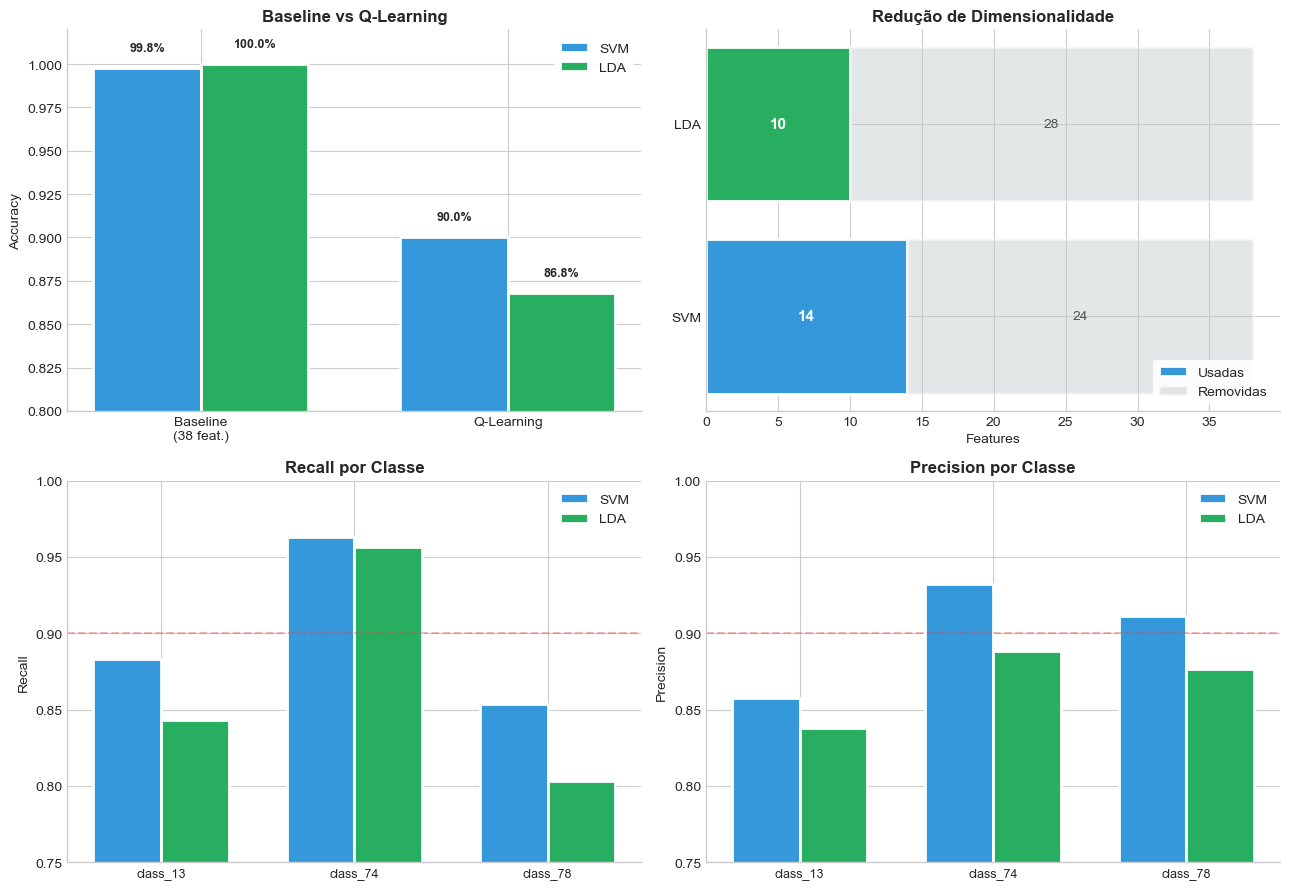

In [18]:
# Gráficos comparativos de performance
# Quatro visualizações para analisar diferentes aspetos dos resultados

# Criar figura com grelha 2x2
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# Gráfico 1: Accuracy - Baseline vs Q-Learning
# Compara a accuracy dos modelos com todas as features vs features selecionadas
ax = axes[0, 0]
x = np.arange(2)  # posições das barras
w = 0.35          # largura das barras

# Barras para SVM (azul) e LDA (verde)
ax.bar(x - w/2, [baseline_svm, eval_svm['val_acc']], w, label='SVM', color=COLORS['svm'], edgecolor='white', lw=2)
ax.bar(x + w/2, [baseline_lda, eval_lda['val_acc']], w, label='LDA', color=COLORS['lda'], edgecolor='white', lw=2)

# Configurar eixos e labels
ax.set_xticks(x)
ax.set_xticklabels(['Baseline\n(38 feat.)', 'Q-Learning'])
ax.set_ylabel('Accuracy')
ax.set_title('Baseline vs Q-Learning')
ax.legend(frameon=True)
ax.set_ylim(0.8, 1.02)

# Adicionar valores acima das barras
for i, v in enumerate([baseline_svm, eval_svm['val_acc']]):
    ax.text(i - w/2, v + 0.01, f'{v:.1%}', ha='center', fontsize=9, fontweight='bold')
for i, v in enumerate([baseline_lda, eval_lda['val_acc']]):
    ax.text(i + w/2, v + 0.01, f'{v:.1%}', ha='center', fontsize=9, fontweight='bold')

# Gráfico 2: Redução de Dimensionalidade
# Barras empilhadas mostrando features usadas vs removidas
ax = axes[0, 1]
models = ['SVM', 'LDA']
selected = [len(results_svm['best_features']), len(results_lda['best_features'])]
removed = [n_features - s for s in selected]

# Barras horizontais: features usadas (coloridas) + removidas (cinzento)
ax.barh(models, selected, color=[COLORS['svm'], COLORS['lda']], edgecolor='white', lw=2, label='Usadas')
ax.barh(models, removed, left=selected, color=COLORS['gray'], alpha=0.4, edgecolor='white', lw=2, label='Removidas')
ax.set_xlabel('Features')
ax.set_title('Redução de Dimensionalidade')
ax.legend(frameon=True, loc='lower right')

# Adicionar números dentro das barras
for i, (s, r) in enumerate(zip(selected, removed)):
    ax.text(s/2, i, str(s), ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    ax.text(s + r/2, i, str(r), ha='center', va='center', fontsize=10, color='#555')

# Gráfico 3: Recall por Classe
# Compara a taxa de acerto para cada classe entre os dois modelos
ax = axes[1, 0]
x = np.arange(3)  # 3 classes

# Calcular recall para cada classe: TP / (TP + FN)
# Usando a diagonal da matriz de confusão dividida pela soma da linha
recall_svm = [eval_svm['cm'][i,i]/eval_svm['cm'][i,:].sum() for i in range(3)]
recall_lda = [eval_lda['cm'][i,i]/eval_lda['cm'][i,:].sum() for i in range(3)]

ax.bar(x - w/2, recall_svm, w, color=COLORS['svm'], edgecolor='white', lw=2, label='SVM')
ax.bar(x + w/2, recall_lda, w, color=COLORS['lda'], edgecolor='white', lw=2, label='LDA')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_, fontsize=9)
ax.set_ylabel('Recall')
ax.set_title('Recall por Classe')
ax.legend(frameon=True)
ax.set_ylim(0.75, 1.0)
ax.axhline(0.9, color=COLORS['accent'], ls='--', alpha=0.4, lw=1.5)  # linha de referência 90%

# Gráfico 4: Precision por Classe
# Compara a precisão para cada classe
ax = axes[1, 1]

# Calcular precision para cada classe: TP / (TP + FP)
# Usando a diagonal da matriz de confusão dividida pela soma da coluna
prec_svm = [eval_svm['cm'][i,i]/eval_svm['cm'][:,i].sum() for i in range(3)]
prec_lda = [eval_lda['cm'][i,i]/eval_lda['cm'][:,i].sum() for i in range(3)]

ax.bar(x - w/2, prec_svm, w, color=COLORS['svm'], edgecolor='white', lw=2, label='SVM')
ax.bar(x + w/2, prec_lda, w, color=COLORS['lda'], edgecolor='white', lw=2, label='LDA')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_, fontsize=9)
ax.set_ylabel('Precision')
ax.set_title('Precision por Classe')
ax.legend(frameon=True)
ax.set_ylim(0.75, 1.0)
ax.axhline(0.9, color=COLORS['accent'], ls='--', alpha=0.4, lw=1.5)  # linha de referência 90%

plt.tight_layout()
plt.show()

In [19]:
# Análise das features selecionadas por cada modelo
# Identifica features exclusivas de cada modelo e features comuns a ambos

# Converter listas de índices para conjuntos (sets) para facilitar operações
svm_set = set(results_svm['best_features'])
lda_set = set(results_lda['best_features'])

# Calcular interseção (features comuns) e diferenças (features exclusivas)
common = svm_set & lda_set      # interseção: features selecionadas por ambos
only_svm = svm_set - lda_set    # diferença: features apenas no SVM
only_lda = lda_set - svm_set    # diferença: features apenas no LDA

# Mostrar features exclusivas do SVM
print(f"Exclusivas SVM ({len(only_svm)}):")
for idx in sorted(only_svm):
    print(f"  - {feature_names[idx]}")

# Mostrar features exclusivas do LDA
print(f"\nExclusivas LDA ({len(only_lda)}):")
for idx in sorted(only_lda):
    print(f"  - {feature_names[idx]}")

# Mostrar features comuns (selecionadas por ambos os modelos)
# Estas são particularmente interessantes pois indicam relevância universal
print(f"\nComuns a ambos ({len(common)}):")
for idx in sorted(common):
    print(f"  - {feature_names[idx]}")

Exclusivas SVM (9):
  - popularity_level
  - tempo_class
  - time_signature
  - album_freq
  - purity_score
  - artists_avg_popularity
  - energy_rank_pct
  - ambient_level
  - key_sin

Exclusivas LDA (5):
  - intensity_level
  - acoustics_instrumental
  - loudness_yeo
  - is_instrumental
  - duration

Comuns a ambos (5):
  - artist_song_count
  - movement_index
  - tempo_vs_genre
  - mood_pca
  - signal_strength


### Interpretação das Features

**Features Comuns (5):** A concordância entre dois classificadores diferentes é um forte indicador de relevância. Estas 5 features capturam informação que é útil independentemente da estratégia de classificação:

| Feature | Interpretação provável |
|---------|------------------------|
| `artist_song_count` | Número de músicas do artista no dataset — pode correlacionar-se com experiência ou estilo |
| `movement_index` | Índice de movimento/dinâmica — diferencia músicas mais estáticas de mais energéticas |
| `tempo_vs_genre` | Relação entre tempo e género — indica se o tempo é típico para o género |
| `mood_pca` | Componente principal do mood — resume a dimensão emocional dominante |
| `signal_strength` | Força do sinal — relacionada com qualidade de produção ou energia sonora |

**Features Exclusivas do SVM (9):** O SVM selecionou mais features relacionadas com metadados e popularidade: `popularity_level`, `artists_avg_popularity`, `album_freq`. Também incluiu características estruturais como `time_signature` e a transformação trigonométrica `key_sin`. Esta última é particularmente interessante — a codificação sinusoidal da tonalidade preserva a natureza cíclica das notas musicais (dó está próximo de si, apesar de terem valores numéricos distantes).

**Features Exclusivas do LDA (5):** O LDA focou-se em propriedades acústicas: `intensity_level` (a feature dominante), `loudness_yeo` (loudness transformada), `acoustics_instrumental` e `is_instrumental`. A inclusão de `duration` sugere que a duração das músicas varia sistematicamente entre classes.

**Reflexão:** Esta divergência faz sentido à luz das diferenças entre os classificadores. O SVM trabalha bem com features diversificadas porque encontra hiperplanos de separação em espaços de alta dimensão. O LDA, que procura projeções lineares ótimas assumindo distribuições gaussianas, beneficia de features com distribuições bem comportadas e forte poder discriminativo — daí a sua dependência de `intensity_level`.

---
## 10. Conclusões

Síntese final dos resultados obtidos com o Q-Learning para seleção de features.

O gráfico resume visualmente o impacto da seleção de features na accuracy de cada modelo, permitindo uma comparação direta entre as configurações baseline e otimizadas.

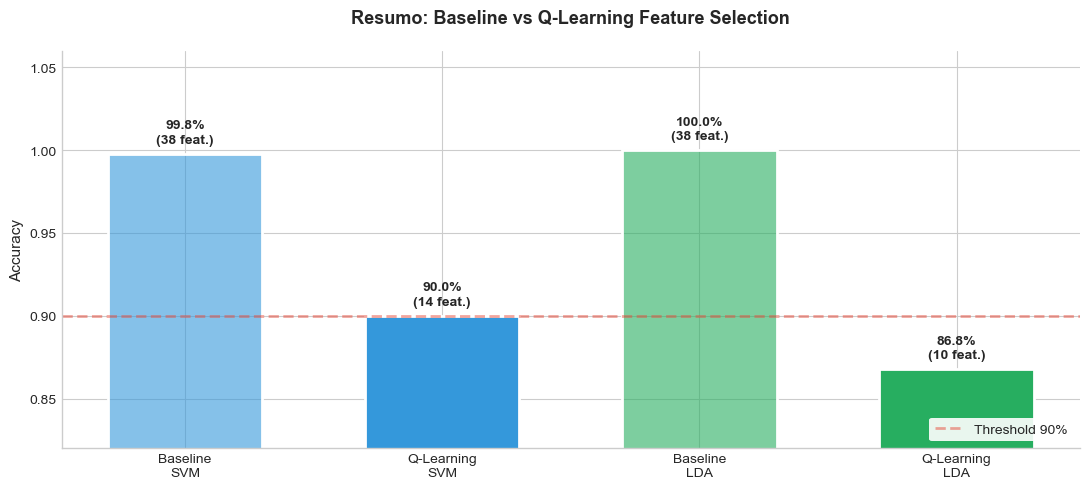

In [20]:
# Gráfico resumo final
# Comparação visual direta entre baseline e Q-Learning para ambos os modelos

# Criar figura
fig, ax = plt.subplots(figsize=(11, 5))

# Definir dados para o gráfico
# 4 barras: Baseline SVM, Q-Learning SVM, Baseline LDA, Q-Learning LDA
categories = ['Baseline\nSVM', 'Q-Learning\nSVM', 'Baseline\nLDA', 'Q-Learning\nLDA']
accuracies = [baseline_svm, eval_svm['val_acc'], baseline_lda, eval_lda['val_acc']]

# Cores: baseline mais claro (com transparência), Q-Learning mais escuro
colors = [COLORS['svm']+'99', COLORS['svm'], COLORS['lda']+'99', COLORS['lda']]

# Número de features para cada configuração
n_features_list = [38, len(results_svm['best_features']), 38, len(results_lda['best_features'])]

# Desenhar barras
bars = ax.bar(categories, accuracies, color=colors, edgecolor='white', linewidth=2, width=0.6)

# Adicionar anotações acima de cada barra: accuracy e número de features
for bar, acc, n_f in zip(bars, accuracies, n_features_list):
    ax.annotate(f'{acc:.1%}\n({n_f} feat.)', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 8), textcoords="offset points", 
                ha='center', fontsize=10, fontweight='bold')

# Configurar eixos e título
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Resumo: Baseline vs Q-Learning Feature Selection', fontsize=13, fontweight='bold', pad=20)
ax.set_ylim(0.82, 1.06)

# Linha de referência a 90% (threshold comum de boa performance)
ax.axhline(0.9, color=COLORS['accent'], ls='--', alpha=0.5, lw=2, label='Threshold 90%')
ax.legend(loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

### Síntese dos Resultados

| Métrica | SVM-LINEAR | LDA |
|---------|------------|-----|
| Baseline (38 features) | 99.78% | 100.00% |
| Q-Learning | 90.00% | 86.78% |
| Diferença | -9.78 p.p. | -13.22 p.p. |
| Features selecionadas | 14 (37%) | 10 (26%) |
| Redução dimensional | 63% | 74% |

*Nota: Baseline calculado com Holdout 70/30, consistente com a avaliação do Q-Learning.*

### O que aprendemos

**O Q-Learning funciona para seleção de features:** Com apenas 15 episódios de treino, o algoritmo conseguiu identificar subconjuntos que reduzem a dimensionalidade em 63-74% mantendo accuracy entre 87-90%. O processo é computacionalmente leve e produziu resultados interpretáveis.

**A função de reward molda os resultados:** A penalização deliberada de subconjuntos com accuracy de treino ≥99% teve o efeito pretendido — os modelos resultantes não atingem perfeição, mas também evitam memorização. Se o objetivo fosse maximizar accuracy pura, a função de reward teria de ser redesenhada.

**Features diferentes para modelos diferentes:** Apenas 5 das features selecionadas são comuns aos dois modelos. Isto confirma que a "importância" de uma feature depende do classificador usado. Não existe um subconjunto universalmente ótimo.

**class_74 é fácil, class_78 é difícil:** Este padrão mantém-se independentemente do modelo ou número de features. Provavelmente reflete propriedades intrínsecas dos dados — class_74 tem características distintivas claras, enquanto class_78 partilha atributos com class_13.

### Limitações

- **Estocasticidade:** Diferentes execuções produzem subconjuntos diferentes. Os resultados apresentados dependem da seed 42.
- **Exploração limitada:** 15 episódios exploram uma fração ínfima dos $2^{38}$ subconjuntos possíveis.
- **Threshold conservador:** O limiar de 99% pode ser demasiado restritivo para este dataset, forçando redução de accuracy desnecessária.

### Quando usar cada modelo

- **Maximizar accuracy:** Usar os modelos baseline com todas as 38 features (~100%)
- **Reduzir complexidade:** O SVM com 14 features oferece 90% accuracy — um compromisso razoável para aplicações onde a simplicidade é valorizada
- **Interpretabilidade:** As 5 features comuns (`artist_song_count`, `movement_index`, `tempo_vs_genre`, `mood_pca`, `signal_strength`) são candidatas naturais para análises explicativas